$SF_\infty = \hat{\sigma} \sqrt{\tau}$ and $\sigma = \hat{\sigma} \sqrt{\tau / 2} = SF_\infty / \sqrt{2}$.

In [1]:
import numpy as np

# set parameters
tau = 100 #signal decorrelation timescale in days
sf = 0.2
sigma_hat = sf/np.sqrt(tau) # modified variability amplitude
sigma = sf/np.sqrt(2)
delta_t = 2 # observational cadence delta_t = t_i+1 - t_i

s = np.zeros(2000)
t = 0

while t < 2000:
    if t == 0:
        s[t] = np.random.normal(loc=0,scale=sigma) #for the 0th point, draw from Gaussian deviate of width sigma
        t = t + 1
        # print('Here! t = ' + str(t))
    else:
        s[t] = s[t-1]*np.exp(-delta_t/tau) + np.random.normal(loc=0,scale=sigma*np.sqrt(1-np.exp(-2*delta_t/tau)))
        t = t + 1
        # print('Here! t = ' + str(t))

# light curve is actually s + Gaussian noise + mean magnitude

mean_mag = 18 #mean mag
photometric_noise = np.random.normal(loc=0,scale=0.01,size=len(s))

y = s + mean_mag + photometric_noise


/var/folders/f0/bpm69fqn0jl4w0k0w01_lftw0000gn/T/ipykernel_14158/2276496376.py:7: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


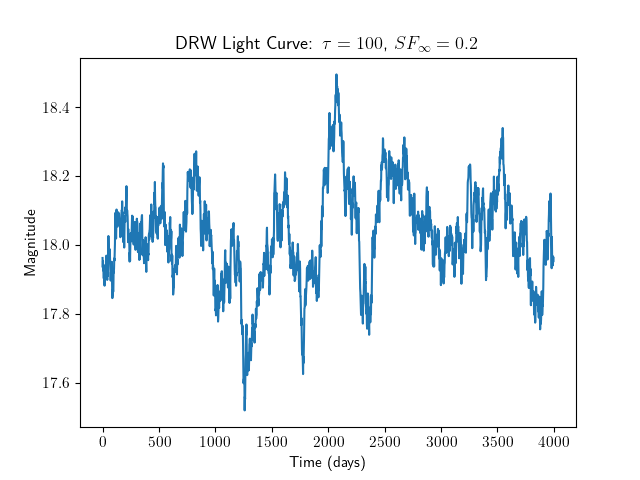

In [6]:
from matplotlib import rc
import matplotlib

### LaTeX Font for plotting ###
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Times-Roman']})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
matplotlib.rcParams.update({'font.size': 11})
##########

import matplotlib.pyplot as plt
%matplotlib widget

t = range(0,4000,2)

plt.plot(t,y)
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')
plt.title('DRW Light Curve: $\\tau = {}$'.format(tau) + ', $SF_\\infty = {}$'.format(sf))

plt.savefig("Report Figures/drw-light-curve.pdf", bbox_inches='tight')


In [87]:
# idk how Bayesian model fitting will work for a damped random walk... but anyway
import scipy.stats as sts
import dynesty
# from dynesty import plotting as dyplot

def model(time_scale,amp):
    sigma = amp*np.sqrt(time_scale/2)
    t=0
    s = np.zeros(2000)
    while t < 2000:
        if t == 0:
            s[t] = np.random.normal(loc=0,scale=sigma) #for the 0th point, draw from Gaussian deviate of width sigma
            t = t + 1
            # print('Here! t = ' + str(t))
        else:
            s[t] = s[t-1]*np.exp(-delta_t/time_scale) + np.random.normal(loc=0,scale=sigma*np.sqrt(1-np.exp(-2*delta_t/time_scale)))
            t = t + 1
    return s + 18
            # print('Here! t = ' + str(t))

def prior_transform(uTheta):
    uTime_scale, uAmp = uTheta
    time_scale = 150*uTime_scale # uniform between 0 and 150
    amp = 0.1*uAmp # uniform between 0 and 0.1
    return time_scale, amp

def lnlike(Theta):
    time_scale, amp = Theta
    y_val = model(time_scale,amp)
    return sum(sts.norm.logpdf(y,loc=y_val,scale=sigma))
    
dsampler = dynesty.DynamicNestedSampler(lnlike, prior_transform, ndim=2)
dsampler.run_nested(print_progress=True)


    

4568it [1:37:53,  3.09s/it, batch: 0 | bound: 867 | nc: 228 | ncall: 817007 | eff(%):  0.559 | loglstar:   -inf < 975.646 <    inf | logz: 962.771 +/-  0.217 | dlogz: 294.575 >  0.010] Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/dynesty/dynesty.py", line 982, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/var/folders/f0/bpm69fqn0jl4w0k0w01_lftw0000gn/T/ipykernel_67928/3030410087.py", line 29, in lnlike
    y_val = model(time_scale,amp)
  File "/var/folders/f0/bpm69fqn0jl4w0k0w01_lftw0000gn/T/ipykernel_67928/3030410087.py", line 16, in model
    s[t] = s[t-1]*np.exp(-delta_t/time_scale) + np.random.normal(loc=0,scale=sigma*np.sqrt(1-np.exp(-2*delta_t/time_scale)))
KeyboardInterrupt
4568it [1:37:53,  1.29s/it, batch: 0 | bound: 867 | nc: 228 | ncall: 817007 | eff(%):  0.559 | loglstar:   -inf < 975.646 <    inf | logz: 962.771 +/-  0.217 | dlogz: 294.575 >  0.010]

Exception while calling loglikelihood function:
  params: [5.52139114e+01 1.19443173e-02]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [72]:
(s*s).mean()

0.02071170391231226

In [74]:
s.var()

0.02050307097315799

array(0.00088429)